# Intro
We're going to learn how to classify images using machine learning.


## Table of Contents


1. Setup
2. Data Preprocessing
    - a. Create Directories
    - b. Creating Generators
3. Training Model
4. Evaluation
    - a. Evaluation on Test Set
    - b. Visualizing Predictions
    - c. Visualizing Activation Maps
    - d. Visualizing Training Process
5. Data Augmentation
6. Saving
7. Loading
8. Conclusion

## Project Setup
- Import necessary libs
- Do stuff

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp
from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Data Preprocessing

In [24]:
INCLUDE_TEST = True
CAT_DIR = './training_data/Cat'
DOG_DIR = './training_data/Dog'
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

def make_directories():
  try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
  except OSError:
      print('Error failed to make directory')

def view_directories():
  print('Sample Data Count:')
  print(f"Training Cats: {len(os.listdir('/tmp/cats-v-dogs/training/cats'))}")
  print(f"Training Dogs: {len(os.listdir('/tmp/cats-v-dogs/training/dogs'))}")

  print(f"Validation Cats: {len(os.listdir('/tmp/cats-v-dogs/validation/cats'))}")
  print(f"Validation Dogs: {len(os.listdir('/tmp/cats-v-dogs/validation/dogs'))}")

  print(f"Test Cats: {len(os.listdir('/tmp/cats-v-dogs/test/cats'))}")
  print(f"TestDogs: {len(os.listdir('/tmp/cats-v-dogs/test/dogs'))}")

make_directories()
view_directories()

Error failed to make directory
Sample Data Count:
Training Cats: 11250
Training Dogs: 11250
Validation Cats: 625
Validation Dogs: 625
Test Cats: 625
TestDogs: 625


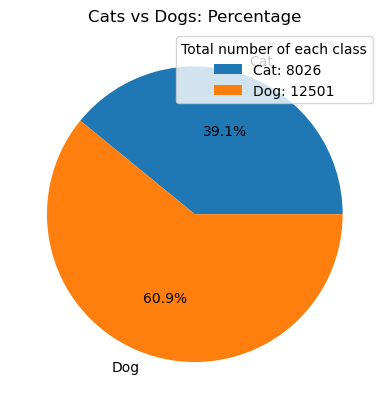

In [25]:
def print_overview():
    class_names = ['Cat', 'Dog'] 
    n_dogs = len(os.listdir(CAT_DIR))
    n_cats = len(os.listdir(DOG_DIR))
    n_images = [n_cats, n_dogs]
    fig, ax = plt.subplots()
    ax.pie(n_images, labels=class_names, autopct='%1.1f%%')
    ax.set_title('Cats vs Dogs: Percentage')
    legend_labels = [f'{class_name}: {n}' for class_name, n in zip(class_names, n_images)]
    ax.legend(legend_labels, title="Total number of each class")
    plt.show()

print_overview()


In [27]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True,  split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)

    shuffled_files = random.sample(files,  len(files))
    split = int(0.9 * len(shuffled_files))
    train = shuffled_files[:split]
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test]
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element),
                 os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element),
                 os.path.join(validation_dir, element))

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element),
                     os.path.join(test_dir, element))
    print("Split successful!")
# split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
# split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

In [28]:
train_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

validation_gen =  ImageDataGenerator(rescale=1./255.)
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(rescale=1./255.)
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22499 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


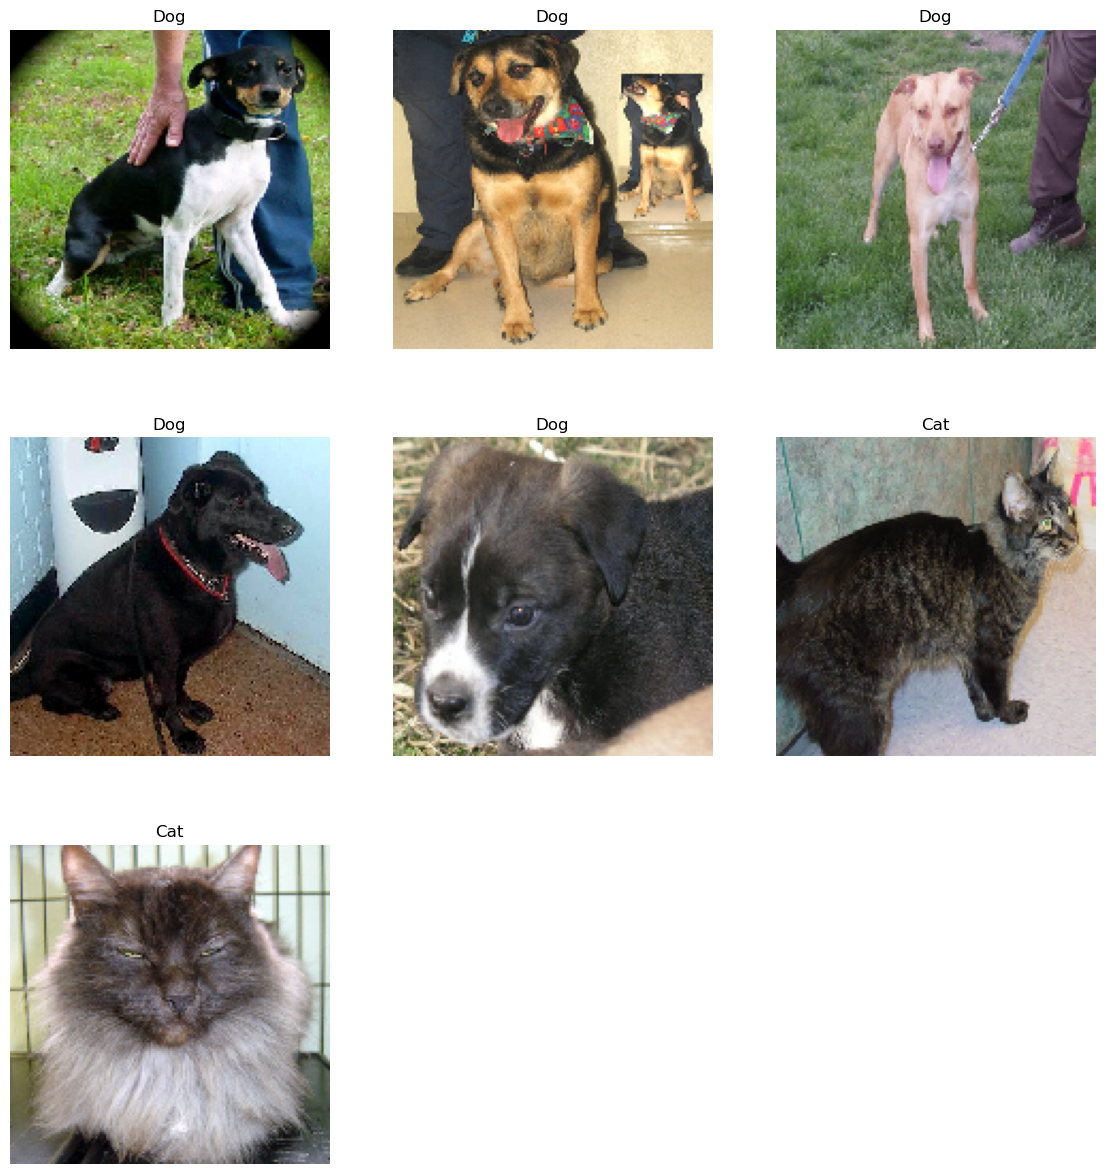

In [32]:
class_names = ['Cat', 'Dog']


def plot_data(generator, n_images):
    i = 0
    plt.figure(figsize=(14, 15))
    for batch in generator:
        images, labels = batch
        labels = labels.astype('int32')
        for image, label in zip(images, labels):
            if i >= n_images:
                break
            plt.subplot((n_images // 3) + 1, 3, i + 1)
            plt.imshow(image)
            plt.title(class_names[label])
            plt.axis('off')
            i += 1
        if i >= n_images:
            break
    plt.show()


plot_data(train_generator, 7)

## Training Model

In [36]:
def train_model():
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    r = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)
    return [model, r]


[model, r] = train_model()

Epoch 1/10
312/352 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5088 - loss: 0.6932

/Users/future/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5118 - loss: 0.6925

/Users/future/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.5119 - loss: 0.6925 - val_accuracy: 0.5909 - val_loss: 0.6748
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.6091 - loss: 0.6550 - val_accuracy: 0.6733 - val_loss: 0.6164
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.6620 - loss: 0.6131 - val_accuracy: 0.7102 - val_loss: 0.5752
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.6923 - loss: 0.5854 - val_accuracy: 0.6261 - val_loss: 0.6854
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.7175 - loss: 0.5654 - val_accuracy: 0.7198 - val_loss: 0.5686
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.7209 - loss: 0.5568 - val_accuracy: 0.7518 - val_loss: 0.5218
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.7406 - loss: 0.5314 - val_accuracy: 0.7502 - val_loss: 0.5211
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.7557 - loss: 0.5118 - val_accuracy: 0.772

In [ ]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

In [ ]:
def plot_prediction(generator, n_images):
    i = 1
    images, labels = generator.next()
    predictions = model.predict(images)
    predictions = np.argmax(predictions, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

In [ ]:
# Create a model to visualize activation maps
gp_weights =  model.get_layer('dense').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

images, _ = test_generator.next()
features, results = activation_model.predict(images)

In [ ]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image
    
    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()


In [ ]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated 
    '''
    counter = 0
    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

In [ ]:
show_maps(desired_class=1, num_maps=5)

## Visualize Training Process

In [ ]:
results = pd.DataFrame(r.history)
results.tail()

In [ ]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

## Data Augmentation

In [ ]:
train_gen_aug = ImageDataGenerator(
    rescale=1./255, fill_mode='nearest', horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug = ImageDataGenerator(
    rescale=1./255.)


train_generator = train_gen_aug.flow_from_directory(
    '/tmp/cats-v-dogs/training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
    '/tmp/cats-v-dogs/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model_aug = Model(inputs=inputs, outputs=x)

model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

r = model_aug.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

results = pd.DataFrame(r.history)
results.tail()


fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
r = model_aug.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)


results = pd.DataFrame(r.history)
results.tail()


fig = px.line(results, y=[results['accuracy'], results['val_accuracy']],
              template="seaborn", color_discrete_sequence=['#fad25a', 'red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a", title='Epochs'),
    yaxis=dict(color="#fad25a")
)
fig.show()

## Saving

In [ ]:
save_dir = './'
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_path = os.path.join(save_dir, 'my_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

## Loading

In [ ]:
loaded_model = tf.keras.models.load_model('./pet_classifier.h5')
# loaded_model = tf.keras.models.load_model('./pet_classifier')


## References
- https://www.kaggle.com/code/fareselmenshawii/cats-vs-dogs-classification/notebook